<a href="https://colab.research.google.com/github/yeha98555/data-course-sample/blob/main/S5/A6_cf-item-based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Item-based collaborative filtering

## 基礎建設

In [8]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [9]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-09 13:03:53--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.1’

All_Beauty.csv.1    100%[===================>]  14.78M  10.2MB/s    in 1.5s    

2022-01-09 13:03:55 (10.2 MB/s) - ‘All_Beauty.csv.1’ saved [15499476/15499476]

--2022-01-09 13:03:55--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.1’

meta_All_Beauty.jso 100%[===================>]   9.85M  7.56MB/s    in 1.3s   

In [10]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [11]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [12]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [13]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

### 去除重複資料

#### metadata（資料完全一樣的商品）

In [14]:
print('Original Num of metadata: {0}'.format(len(metadata)))
print('Num of duplicated metadata: {0}'.format(metadata.duplicated(subset=['asin', 'title']).sum()))

print('Drop duplicated metadata...')
metadata.drop_duplicates(subset=['asin', 'title'], keep=False, inplace=True)
metadata = metadata.reset_index(drop=True)
print('Current Num of metadata: {0}'.format(len(metadata)))

Original Num of metadata: 32892
Num of duplicated metadata: 404
Drop duplicated metadata...
Current Num of metadata: 32084


## 資料切分

In [15]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

---

保留原始資料，複製一份出來處理。

In [16]:
metadata_tmp = metadata.copy()

ratings_trainings_tmp = ratings_trainings.copy()
ratings_testings_tmp = ratings_testings.copy()

users_testing_tmp = users.copy()

---

## 資料探索

In [17]:
import numpy as np
import matplotlib.pyplot as plt

### 測試資料集

查看測試資料集中的用戶有多少人曾經留下評分過？各留下多少呢？

In [18]:
num_rating_user = ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)]['reviewerID'].nunique()
print('多少人曾留過評分 : {0} ({1}%)'.format(num_rating_user, round(num_rating_user / len(users_testing_tmp)*100)))

多少人曾留過評分 : 38 (7%)


In [20]:
print(ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)].groupby('reviewerID').agg({'asin':'size'}))
print('這些人平均對多少商品評分: {0}'.format(ratings_trainings_tmp[ratings_trainings_tmp['reviewerID'].isin(users_testing_tmp)].groupby('reviewerID').agg({'asin':'size'}).mean()[0]))

                asin
reviewerID          
A13JU88JAHN72I     1
A16Y7V1CZCWKFV     1
A19503XX7GU6J2     2
A1EY751AUVO5NZ     1
A1PR178735XC70     1
A1SA3N793WT2LM     4
A1TP9JHTIY468V     2
A1UAOE8KO7Q1DZ     1
A1WEFBEJ7OHSVZ     1
A1WSZED2O5MA5T     2
A28E3FNV1BYC94     1
A29834GBB4DOP1     1
A2AAQWBJJTK3E1     1
A2BU6N5956T9NH     1
A2GFPTQ4VWDX96     1
A2IMJV0CQMZLGC     1
A2IOBG1ERS4JP3     1
A2JCBLTLYDPQLW     1
A2M4YSOJZELJ6N     1
A2XFJ8CTY7VDNN     1
A2XY3CJ3ZCAD03     1
A3BE6JK97CYAGA     1
A3BT1WLPENXMD6     3
A3DXW3542E4QUC     1
A3GRQ9WMP4OXFE     1
A3H8Z7JS7XJHJJ     2
A3JEQJCEMX20GI     2
A4IQXCCXDEAKW      2
A7JUHUYLXIUVQ      1
A7Y4ETTLARUGI      1
ACE1ZIOI3U6PY      3
AGRZQOBCF8H87      1
AITF34BGBMVJJ      1
AK7YIZE6ZZ1N9      1
ANR73TPVBCQ9K      1
AQYL4TDY2HU8Z      1
ASGIVOW34XNQS      3
ATJRZUXNWAWIK      1
這些人平均對多少商品評分: 1.394736842105263


如果未曾留下評分，則無法得知喜好，也無法找過去購買的商品推薦類似的，只能用rule-based。
發現有留過評分的占少數，故rule-based方法對整體推薦系統recall影響大。

### 訓練資料集

只推薦在商品資料集中的商品，故下面都只討論有在商品資料集的商品。<br>
會這麼做，主要是因為之後想由商品資料集中取特徵，增加商品相似度計算的準確度。

In [21]:
item_in_medadata = metadata_tmp['asin'].tolist()
print('在商品資料表中有 {0} 個商品'.format(len(item_in_medadata)))

在商品資料表中有 32084 個商品


In [22]:
print('原本評分總筆數: {0}'.format(len(ratings_trainings_tmp)))
print('剔除評分商品為在商品資料集中的評分...')
ratings_trainings_tmp = ratings_trainings_tmp[ratings_trainings_tmp['asin'].isin(item_in_medadata)]
print('剔除後評分總筆數: {0}'.format(len(ratings_trainings_tmp)))

原本評分總筆數: 370752
剔除評分商品為在商品資料集中的評分...
剔除後評分總筆數: 349321


#### 在商品資料集中有多少商品被評分？

In [23]:
item_with_rating = ratings_trainings_tmp.asin.unique().tolist()

In [25]:
item_with_rating_in_metadata = metadata_tmp[metadata_tmp['asin'].isin(item_with_rating)]['asin'].tolist()

In [27]:
# 在現有的商品資料(metadata)中有多少資料未被評分過
print('現有商品資料中有 {0} ({1}%) 評分資料，有 {2} 個商品未有過評分紀錄。'.format(
    len(item_with_rating_in_metadata), 
    round(len(item_with_rating_in_metadata) / len(metadata_tmp['asin']) * 100, 2), 
    len(metadata_tmp['asin']) - len(item_with_rating_in_metadata)))

現有商品資料中有 32078 (99.98%) 評分資料，有 6 個商品未有過評分紀錄。


#### 將重複評分以平均評分取代

In [28]:
# 如果只有一筆就直接填該筆評分，如果有多筆，overall_mean填入評分平均值、overall_lastest填入最近的評分值。
ratings_trainings_unique = ratings_trainings_tmp.groupby(['reviewerID', 'asin']) \
                    .agg(overall=('overall', np.mean)) \
                    .reset_index()
ratings_trainings_unique.head()

,reviewerID,asin,overall
0,A0010876CNE3ILIM9HV0,B01FHDYGQ8,5.0
1,A001170867ZBE9FORRQL,B01B18T01Y,5.0
2,A001170867ZBE9FORRQL,B01FCW88D6,5.0
3,A0028738FYF1SKPPC7B1,B00TZ8XK1E,5.0
4,A0045356A23634W7RI4M,B018H0EJI8,3.0


#### 商品資料集中每個商品大多被多少人評分？

In [29]:
ratings_trainings_item = ratings_trainings_unique.groupby('asin') \
       .agg({'reviewerID':'size', 'overall':'mean'}) \
       .rename(columns={'reviewerID':'rating_count','overall':'mean_score'}) \
       .reset_index().sort_values('rating_count', ascending=False)
ratings_trainings_item.head()

,asin,rating_count,mean_score
446,B000FOI48G,8656,4.394235
566,B000GLRREU,8341,4.405107
2797,B001QY8QXM,4505,4.556049
29048,B01DKQAXC0,4191,4.212718
5460,B006IB5T4W,2789,4.643421


In [30]:
print(ratings_trainings_item['rating_count'])
print('這些商品平均對多少用戶評分: {0}'.format(ratings_trainings_item['rating_count'].mean()))

446      8656
566      8341
2797     4505
29048    4191
5460     2789
         ... 
10299       1
10297       1
21963       1
21966       1
16039       1
Name: rating_count, Length: 32078, dtype: int64
這些商品平均對多少用戶評分: 10.587754847559074


但認為只有被一個用戶評分的商品，表示只有一個用戶評分，無法推薦給其他用戶，因為由其他用戶找曾評分商品找到商品後，不會跟這個商品有任何相似，故移除該商品。

In [31]:
print('有被評分的商品總數: {0}'.format(ratings_trainings_unique['asin'].nunique()))
print('剔除只有被一個用戶評分的商品...')
ratings_trainings_item = ratings_trainings_item[ratings_trainings_item['rating_count'] > 1]
print('提除後的商品總數: {0} ({1}%)'.format(
    len(ratings_trainings_item), 
    round(len(ratings_trainings_item) / ratings_trainings_unique['asin'].nunique() *100)))

有被評分的商品總數: 32078
剔除只有被一個用戶評分的商品...
提除後的商品總數: 18742 (58%)


In [32]:
print(ratings_trainings_item['rating_count'])
print('這些商品平均被多少用戶評分: {0}'.format(ratings_trainings_item['rating_count'].mean()))

446      8656
566      8341
2797     4505
29048    4191
5460     2789
         ... 
739         2
5724        2
15204       2
8160        2
4889        2
Name: rating_count, Length: 18742, dtype: int64
這些商品平均被多少用戶評分: 17.409988261658306


In [33]:
ratings_trainings_item['rating_count'].describe()

count    18742.000000
mean        17.409988
std        116.876783
min          2.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       8656.000000
Name: rating_count, dtype: float64

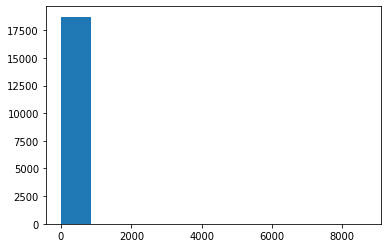

將用戶數超過17個的放大來看...


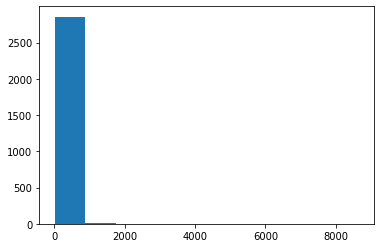

將用戶數超過134個(mean+1*std)的放大來看...


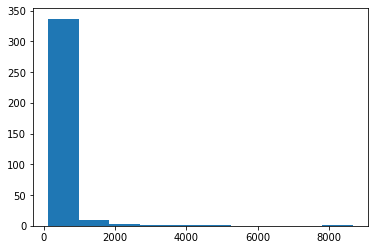

將用戶數超過251個(mean+2*std)的放大來看...


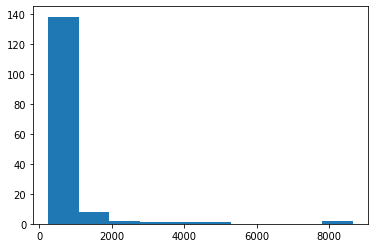

將用戶數超過368個(mean+3*std)的放大來看...


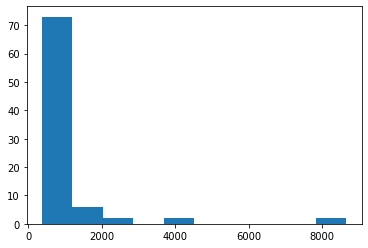

In [34]:
plt.hist(ratings_trainings_item['rating_count'])
plt.show()
print('將用戶數超過17個的放大來看...')
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 17]['rating_count'])
plt.show()
print('將用戶數超過134個(mean+1*std)的放大來看...') # 1*std
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 134]['rating_count'])
plt.show()
print('將用戶數超過251個(mean+2*std)的放大來看...') # 2*std
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 251]['rating_count'])
plt.show()
print('將用戶數超過368個(mean+3*std)的放大來看...') # 2*std
plt.hist(ratings_trainings_item[ratings_trainings_item['rating_count'] > 368]['rating_count'])
plt.show()

發現商品的用戶評分數落差很大，不知道會不會使得結果不太理想，認為或許能加入更多確定且完整的特徵(如:CATEGORY、title等)。<br>
也思考多少個用戶評分才能夠代表一個商品？認為可留到之後測試。

### 商品資料
根據上份作業的資料探索，將多餘欄位剔除，新增有意義欄位(商品評論數、平均評分、季節性等)，主要是想用於新增商品特徵計算商品相似度。

在此的ratings_trainings都不剔除重複評分，視其各自為獨立購買紀錄，皆列入分析計算。

In [35]:
# 剔除有問題的資料
metadata_tmp = metadata_tmp.drop(metadata[metadata['title'] == ''].index).reset_index(drop=True)

In [36]:
# 剔除評分數小於等於1的商品
metadata_tmp = metadata_tmp[metadata_tmp['asin'].isin(ratings_trainings_item['asin'].unique())]

#### 剔除多餘欄位

In [37]:
metadata_tmp = metadata_tmp.drop(['category', 'tech1', 'fit', 'tech2', 'feature', 'date', 'imageURLHighRes', 'main_cat', 'details'], axis=1)

---

## 產生推薦

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender(training_data, users=[], k=10):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in training_data.iterrows():
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

    print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    # skip the item user has rated
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

data converted
data inverted
sim data prepared
get 10 recommendation items for for user: ['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V', 'A1119JJ37ZLB8R', 'A113UOOLBSZN52', 'A12M4U7WK4ALCR', 'A12T8YTW6VWT7S', 'A1364JXGKB46MM', 'A137DALOQFKBTI', 'A13FEZ3WV7S2EY', 'A13IV4I1B0RXMG', 'A13JU88JAHN72I', 'A13K55R6VH1OOD', 'A13P7VFU075A', 'A13SWYE4QLB6NG', 'A13ZTQ0Q4ATA41', 'A142EDN04OD62U', 'A142I22FIC8MZK', 'A14834QTII5TLT', 'A14A447VPACTBC', 'A14AP6MN5XO6LB', 'A14CLF25IX25US', 'A14LYXC3HTBAHI', 'A14VUW4KZ34EOE', 'A14Y32P26G9YL', 'A157T25PBS7MX4', 'A15HZDSERD85C8', 'A15JJ8J1FGADIX', 'A15ZCL70JXXH89', 'A1617KN2IAWZ6J', 'A16E0O88262HKA', 'A16NSZ58PTVIYF', 'A16UGDXRTDLJG5', 'A16X9HR3UFQQXY', 'A16Y7V1CZCWKFV', 'A174YOBOSW9WDN', 'A1786SKRAJXH86', 'A17K2BUZ20WD2', 'A17LYRFV645L0V', 'A18LNGVXDZBTUR', 'A19503XX7GU6J2', 'A19HVHRZDYFEOP', 'A19JM38B861BO4', 'A19KGY3W1P0MHT', 'A19KJPOF3QOJ24', 'A19U5RT4Q8Q1T6', 'A1AQNQUNX8B6JT', 'A1ARU0IN6RUFFD', 'A1BB4635KSKDMV', 'A1BCC7X6KRTBG

{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B000EE9XYG',
  'B007SA3AUW',
  'B000FVHRXC',
  'B001U4RGOS',
  'B01CRWLLX8',
  'B004E4GHRS',
  'B006IB5T4W',
  'B00B0SA1SC',
  'B00JYGWWIO',
  'B00L88S190'],
 'A174Y

## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0